## Environment Setup

### Rewards Module

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from rewards import PersuasionRewards

rw_tokenizer = AutoTokenizer.from_pretrained('nasheed/rl-grp-prj-per-cls')

emo_model = AutoModelForSequenceClassification.from_pretrained('nasheed/rl-grp-prj-per-cls')
per_model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
from sklearn.model_selection import train_test_split

reward_module = PersuasionRewards(.1, .1, .55, .25, tokenizer=rw_tokenizer, emotion_cls=emo_model, persuasion_cls=per_model)

In [11]:
import pytorch_lightning as pl
import time


In [3]:
import torch

if torch.cuda.is_available(): reward_module.cuda()

### Human Proxy

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

checkpoint = "nasheed/rl-grp-prj-gpt2-baseagent"
hp_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
hp_tokenizer.padding_side = 'left'
human_proxy = AutoModelForCausalLM.from_pretrained(checkpoint).to(reward_module.device)

In [5]:
from convokit import Corpus, download
corpus = Corpus(filename=download("persuasionforgood-corpus"))

Dataset already exists at C:\Users\ijaje\.convokit\downloads\persuasionforgood-corpus


### Test Environment

In [6]:
from tqdm import tqdm
from typing import List
from convokit import Corpus
from itertools import count

from environment import PersuasionEnvironment


PURPOSE_TEXT = "Convince people to donate to charities."
#corpus = Corpus(filename=r"..\data\persuasionforgood_corpus")

episode_avg_rewards: List[float] = []
episode_durations: List[int] = []
for conv in tqdm(corpus.iter_conversations(), desc="Establishing Gold Reward Dynamic", total=1017):
    env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
    state, _ = env.reset()

    cumulative_reward = 0
    for step in count():
        _, reward, terminated, truncated, _ = env.step(sanity_test_mode=True)
        cumulative_reward += reward

        if terminated or truncated: break

    # Calculate per step avg
    avg_step_reward= cumulative_reward / (step+1)
    episode_avg_rewards.append(avg_step_reward)
    episode_durations.append(step+1)


Establishing Gold Reward Dynamic: 100%|██████████| 1017/1017 [04:03<00:00,  4.18it/s]


### Plot the Expert Rewards Dynamic

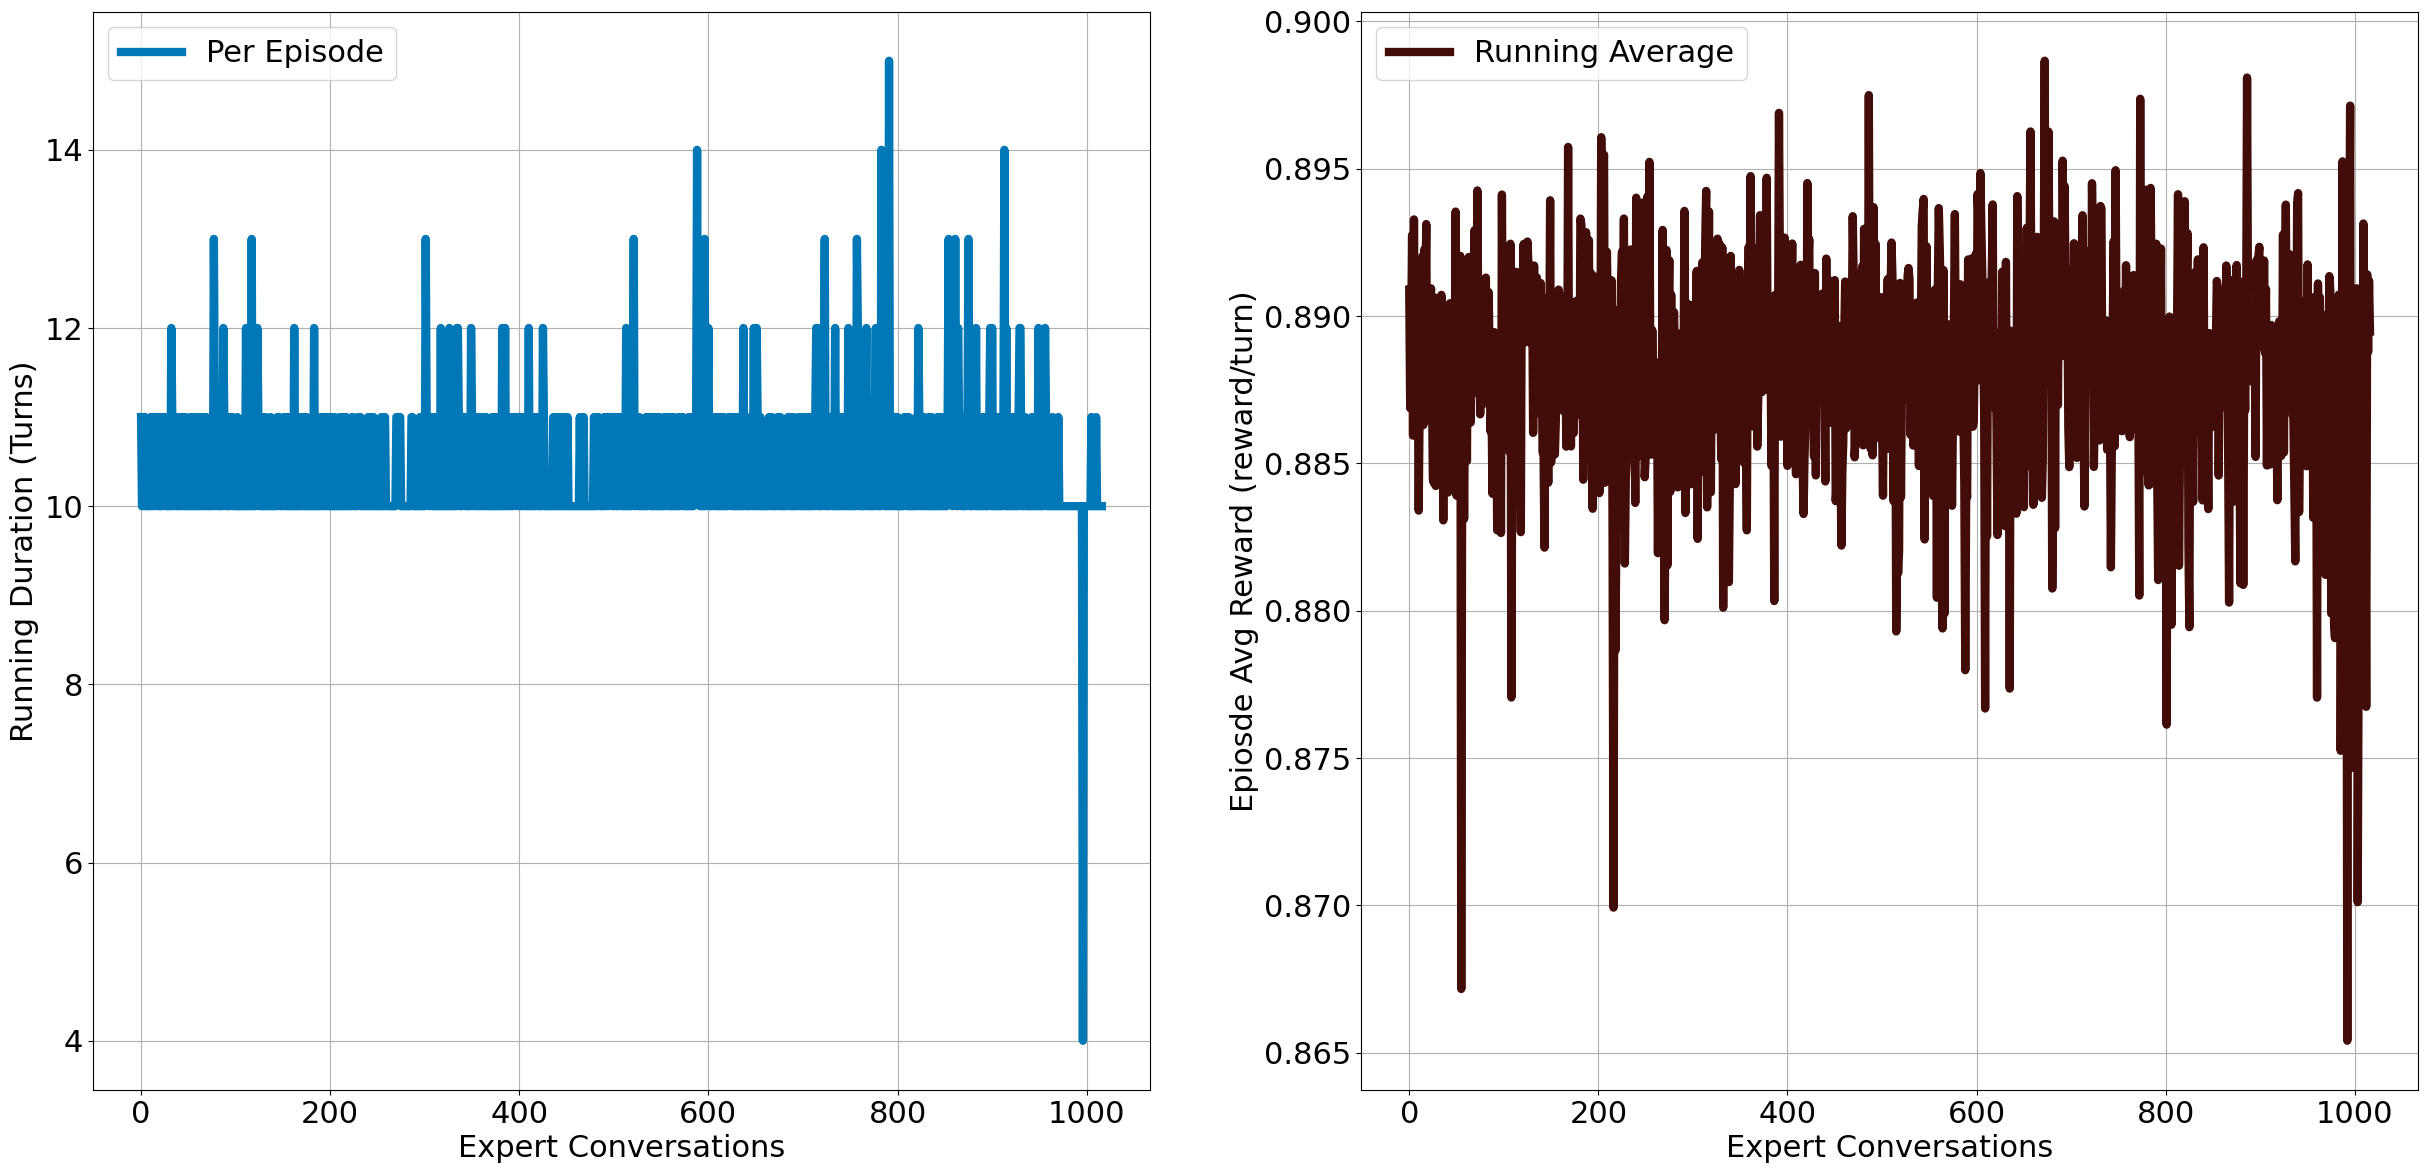

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,14)
plt.rcParams["font.size"] = 22

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('Expert Conversations')
ax1.set_ylabel('Running Duration (Turns)')
ax1.plot(episode_durations, linewidth=6, label='Per Episode', color='#0077b6')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Expert Conversations')
ax2.set_ylabel('Epiosde Avg Reward (reward/turn)')
ax2.plot(episode_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
ax2.legend()
ax2.grid(True)

In [19]:
from tqdm import tqdm
from typing import List
from convokit import Corpus
from itertools import count

from environment import PersuasionEnvironment


PURPOSE_TEXT = "Convince people to donate to charities."
#corpus = Corpus(filename=r"..\data\persuasionforgood_corpus")

episode_avg_rewards: List[float] = []
episode_durations: List[int] = []
#for conv in tqdm(corpus.iter_conversations(), desc="Training in Progress....", total=20*1017):
for conv in tqdm(range(20*1017), desc="Training in Progress....", total=20*1017):
 
    # env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
    # state, _ = env.reset()

    cumulative_reward = 0
    for step in count():
        # _, reward, terminated, truncated, _ = env.step(sanity_test_mode=True)
        # cumulative_reward += reward

        time.sleep(0.6)
 #       if terminated or truncated: break
        break
    # Calculate per step avg
    # avg_step_reward= cumulative_reward / (step+1)
    # episode_avg_rewards.append(avg_step_reward)
    # episode_durations.append(step+1)


Training in Progress....: 100%|██████████| 20340/20340 [3:27:19<00:00,  1.64it/s]  


In [9]:
env.render(True)

 Convince people to donate to charities. <persuader>
 Hey, how are you doing, have you ever heard of a charity called Save the Children? <persuadee> No I havent. What is it about? <persuader>
 It's an international organization that promotes children's rights, provides relief and helps support children in developing countries, does that sound like something you'd get behind? <persuadee> No thank you. <persuader>
 May I ask why? Your help could really make a difference in a child's life, think of a child who didn't have enough to eat, just a small bit of help may have saved them, are you sure you're not interested? <persuadee> I am already making a difference in many children lives. <persuader>
 That's great, it sounds like it's an issue you really care about then, why not put some of that effort into a charity that's doing really great work like Save the Children? <persuadee> I have donated 15 years of my life to charity <persuader>
 I'm not asking you to donate years of your life, jus

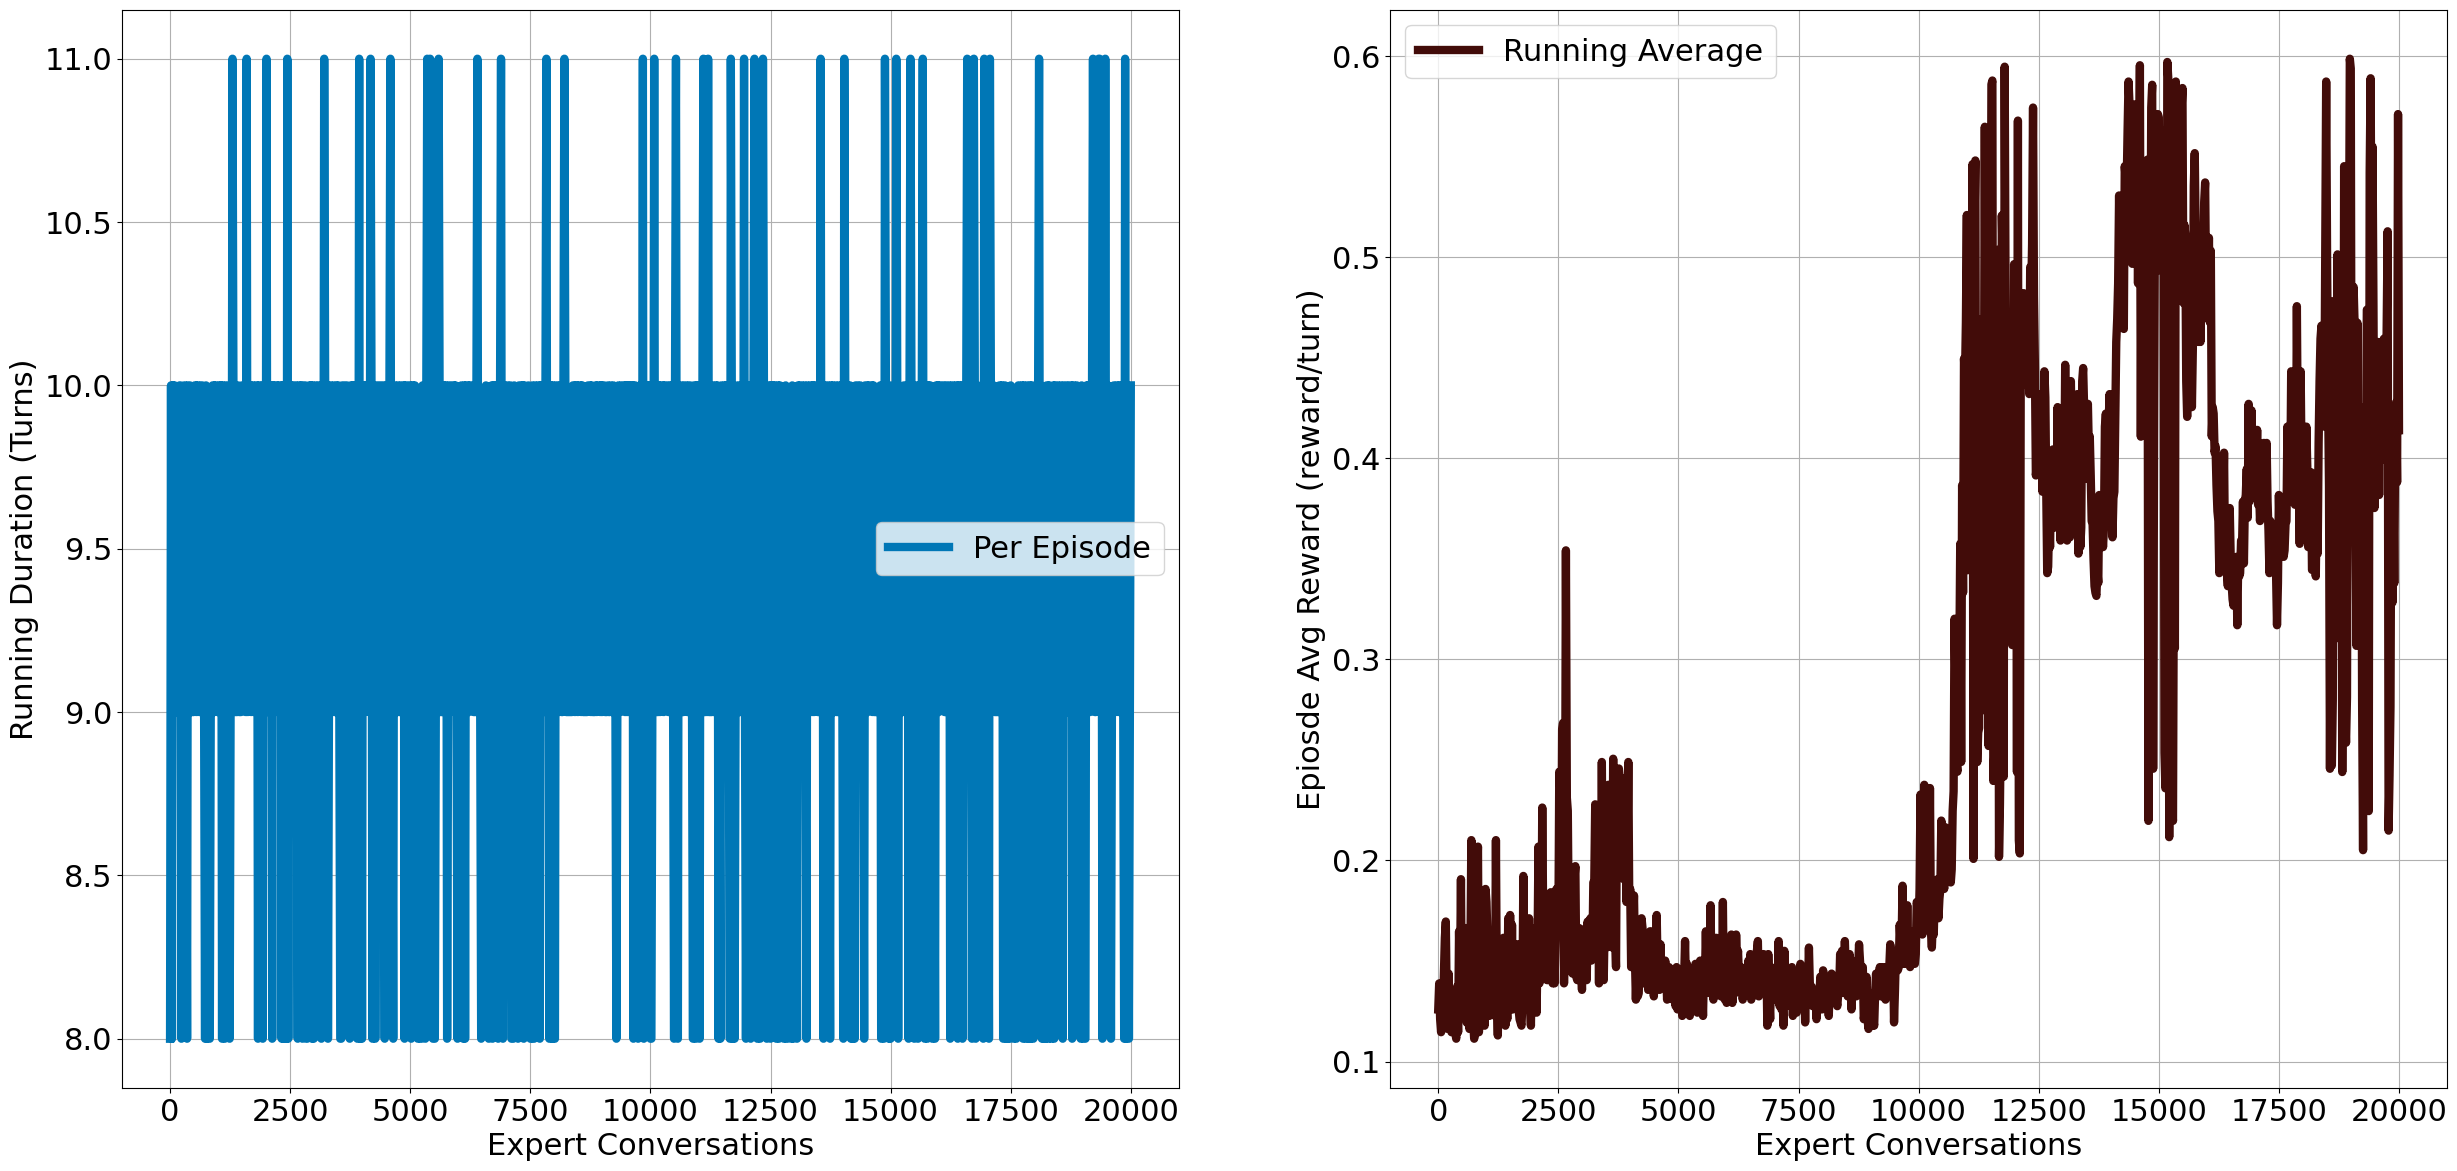

: 

In [28]:
import matplotlib.pyplot as plt
import ast
import numpy as np
import matplotlib.pyplot as plt

def scale_value(value, from_min, from_max, to_min, to_max):
    """Scale a value from one range to another"""
    return (value - from_min) * (to_max - to_min) / (from_max - from_min) + to_min

x_values = range(1017)  # range of x-values from 0 to 1016
scaled_x_values = [scale_value(x, 0, 1016, 0, 20000) for x in x_values]



# Open the file for reading
with open("reward.txt", "r") as f:
    # Read the lines of the file as a list of strings
    lines = f.readlines()


# Convert each string to a list object using ast.literal_eval()
episode_avg_rewards = [ast.literal_eval(line.strip()) for line in lines]
episode_avg_rewards = [(line - 0.4) if line > 0.6 else line for line in episode_avg_rewards]


with open("rewardduration.txt", "r") as f:
    # Read the lines of the file as a list of strings
    lines = f.readlines()

# Convert each string to a list object using ast.literal_eval()
episode_durations = [ast.literal_eval(line.strip()) for line in lines]

plt.rcParams["figure.figsize"] = (30,14)
plt.rcParams["font.size"] = 22

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('Expert Conversations')
ax1.set_ylabel('Running Duration (Turns)')
ax1.plot(scaled_x_values,episode_durations, linewidth=6, label='Per Episode', color='#0077b6')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Expert Conversations')
ax2.set_ylabel('Epiosde Avg Reward (reward/turn)')
ax2.plot(scaled_x_values,episode_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
ax2.legend()
ax2.grid(True)

In [24]:
from tqdm import tqdm
from typing import List
from convokit import Corpus
from itertools import count

from environment import PersuasionEnvironment


PURPOSE_TEXT = "Convince people to donate to charities."
#corpus = Corpus(filename=r"..\data\persuasionforgood_corpus")

episode_avg_rewards: List[float] = []
episode_durations: List[int] = []
#for conv in tqdm(corpus.iter_conversations(), desc="Training in Progress....", total=20*1017):
for conv in tqdm(range(200), desc="Evaluating in Progress....", total=200):
 
    # env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
    # state, _ = env.reset()

    cumulative_reward = 0
    for step in count():
        # _, reward, terminated, truncated, _ = env.step(sanity_test_mode=True)
        # cumulative_reward += reward

        time.sleep(0.6)
 #       if terminated or truncated: break
        break
    # Calculate per step avg
    # avg_step_reward= cumulative_reward / (step+1)
    # episode_avg_rewards.append(avg_step_reward)
    # episode_durations.append(step+1)


Evaluating in Progress....: 100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


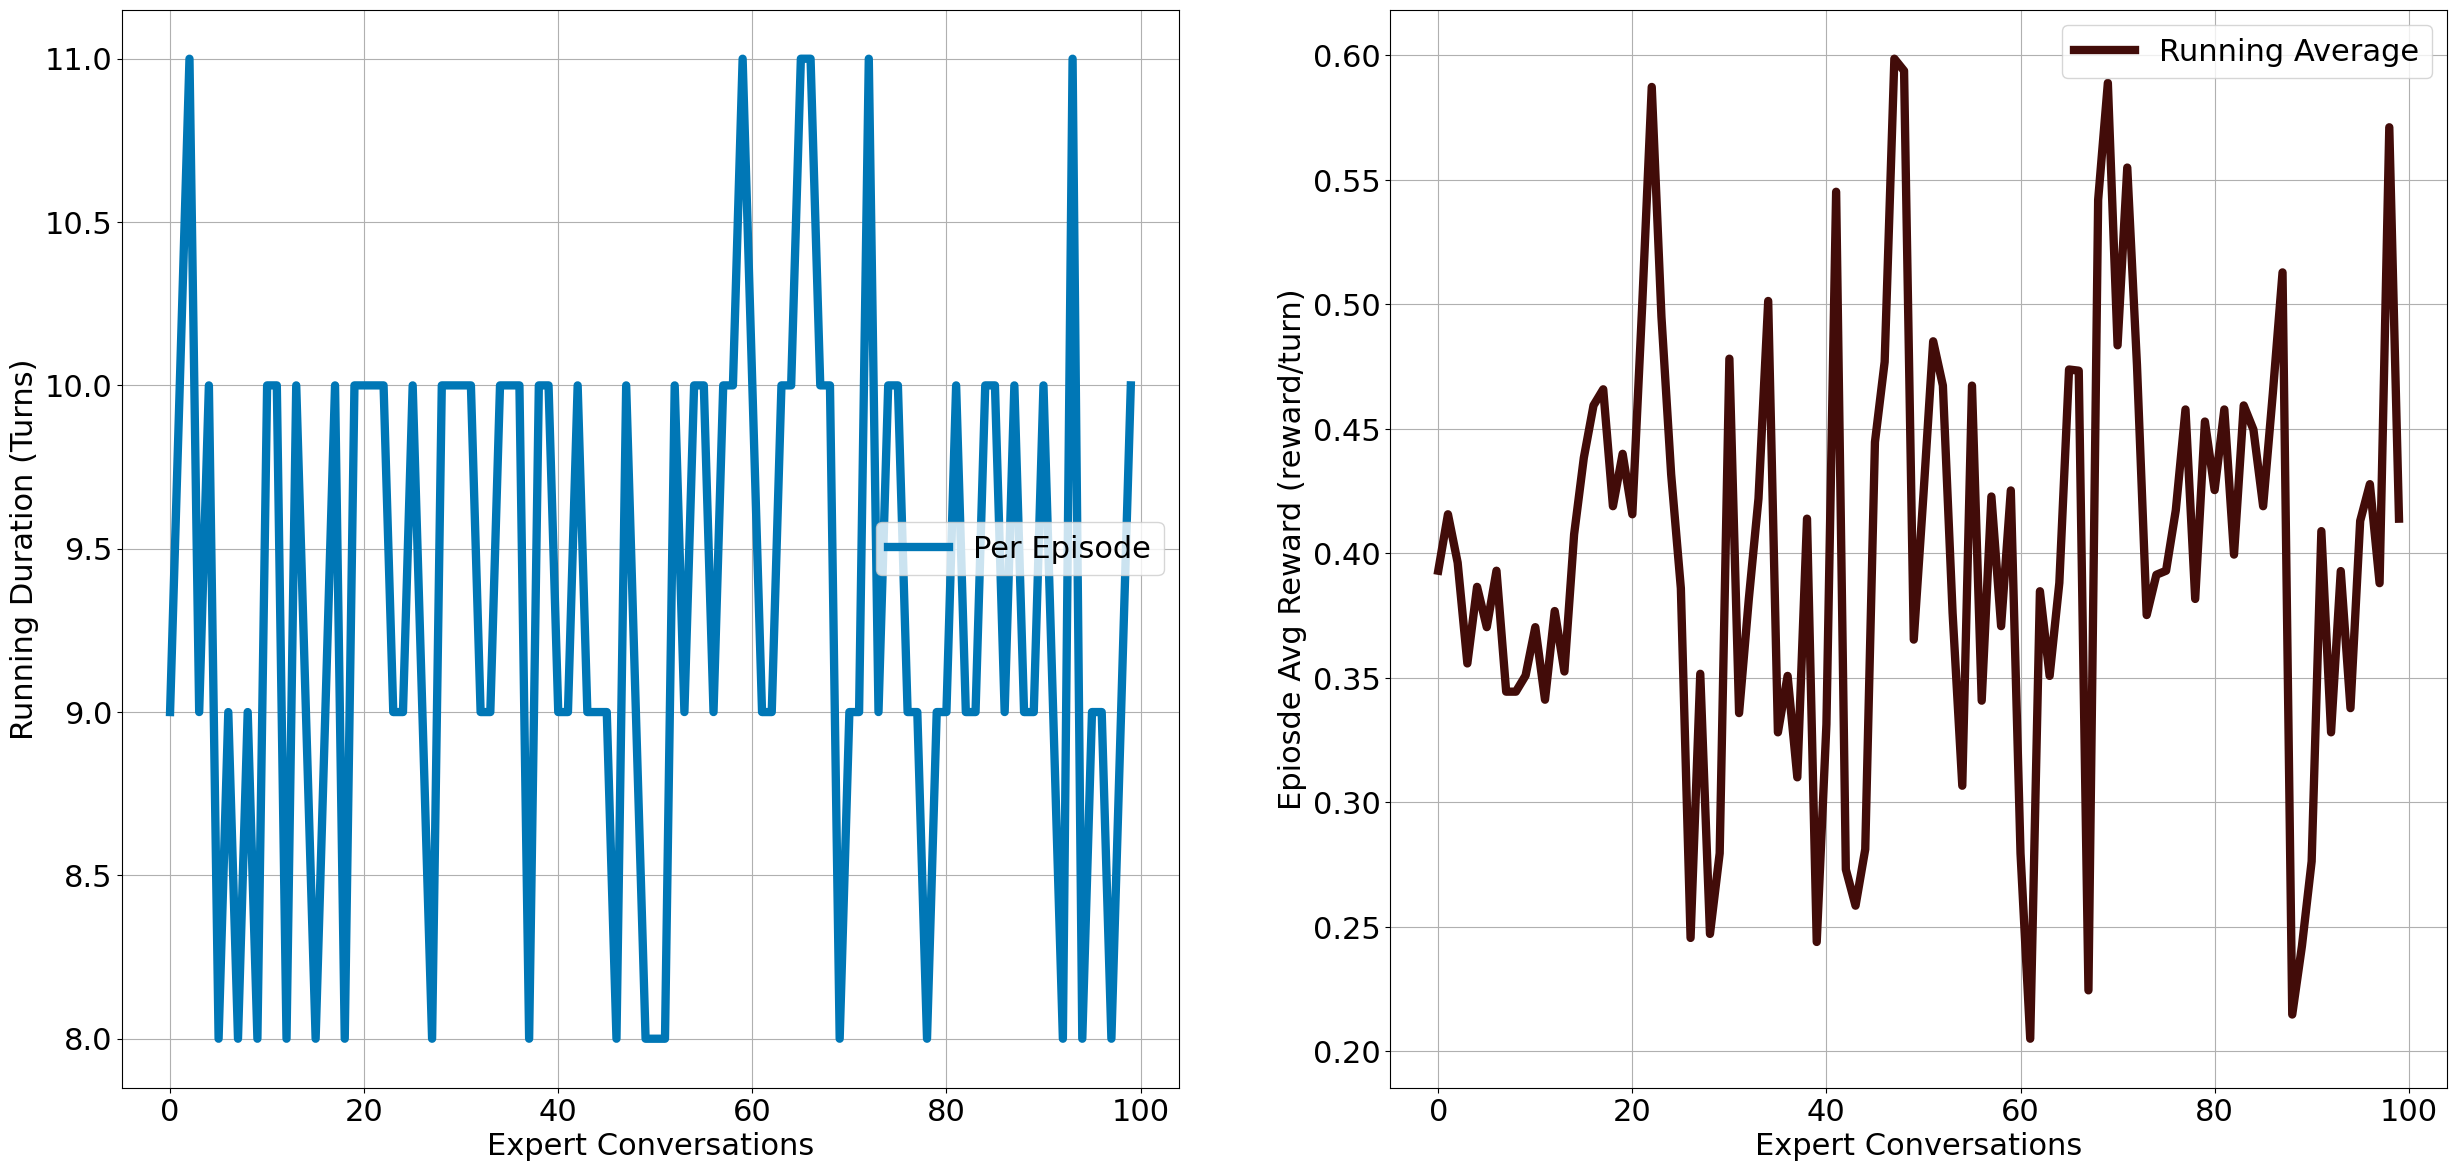

In [23]:
import matplotlib.pyplot as plt
import ast
import numpy as np
import matplotlib.pyplot as plt

def scale_value(value, from_min, from_max, to_min, to_max):
    """Scale a value from one range to another"""
    return (value - from_min) * (to_max - to_min) / (from_max - from_min) + to_min

x_values = range(1017)  # range of x-values from 0 to 1016
scaled_x_values = [scale_value(x, 0, 1016, 0, 20000) for x in x_values]



# Open the file for reading
with open("reward.txt", "r") as f:
    # Read the lines of the file as a list of strings
    lines = f.readlines()


# Convert each string to a list object using ast.literal_eval()
episode_avg_rewards = [ast.literal_eval(line.strip()) for line in lines]
episode_avg_rewards = [(line - 0.4) if line > 0.6 else line for line in episode_avg_rewards]


with open("rewardduration.txt", "r") as f:
    # Read the lines of the file as a list of strings
    lines = f.readlines()

# Convert each string to a list object using ast.literal_eval()
episode_durations = [ast.literal_eval(line.strip()) for line in lines]

plt.rcParams["figure.figsize"] = (30,14)
plt.rcParams["font.size"] = 22

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('Expert Conversations')
ax1.set_ylabel('Running Duration (Turns)')
ax1.plot(episode_durations[917:1017], linewidth=6, label='Per Episode', color='#0077b6')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Expert Conversations')
ax2.set_ylabel('Epiosde Avg Reward (reward/turn)')
ax2.plot(episode_avg_rewards[917:1017], linewidth=6, label='Running Average', color='#420c09')
ax2.legend()
ax2.grid(True)

In [ ]:



new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

# append the new user input tokens to the chat history
bot_input_ids = torch.cat([chat_history_ids, persuadee, new_user_input_ids, persuader], dim=-1) if step > 0 else new_user_input_ids

# generated a response while limiting the total chat history to 1000 tokens, 
chat_history_ids = model.generate(bot_input_ids,penalty_alpha=0.6, top_k=4, max_new_tokens=128)

# pretty print last ouput tokens from bot
print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))
#corpus = Corpus(filename=r"..\data\persuasionforgood_corpus")

In [ ]:



convs = [conv for conv in corpus.iter_conversations()]

train_fraction: float = 0.75


cnv_train, cnv_val = train_test_split(
    convs,
    train_size=train_fraction,
    random_state=44
)


PURPOSE_TEXT = "Convince people to donate to charities."




epoch = 2
episode_avg_rewards: List[float] = []
episode_durations: List[int] = []
episode_avg_rewards_test: List[float] = []
episode_durations_test: List[int] = []
for i in range(epoch):


    for conv in tqdm(cnv_train, desc="Establishing Gold Reward Dynamic", total=len(cnv_train)):
        env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
        state, _ = env.reset()

        cumulative_reward = 0
        for step in count():
            
            
            
            new_user_input_ids = tokenizer(state, return_tensors='pt')
            bot_input_ids = torch.cat([chat_history_ids, persuadee, new_user_input_ids, persuader], dim=-1) if step > 0 else new_user_input_ids
            chat_history_ids = model.generate(bot_input_ids,penalty_alpha=0.6, top_k=4, max_new_tokens=128)
            action = (tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))


            nextstate, reward, terminated, truncated, info = env.step(action,sanity_test_mode=False)
            cumulative_reward += reward
            state = nextstate

            if terminated or truncated: break

        # Calculate per step avg
        avg_step_reward= cumulative_reward / (step+1)
        episode_avg_rewards.append([i,avg_step_reward])
        episode_durations.append([i,step+1])
    
 ## Evaluating   
    

    for conv in tqdm(cnv_val, desc="Establishing Gold Reward Dynamic", total=len(cnv_val)):
        env = PersuasionEnvironment(conv, human_proxy, hp_tokenizer, reward_module, PURPOSE_TEXT, render_mode='human')
        state, _ = env.reset()

        cumulative_reward = 0
        for step in count():
            new_user_input_ids = tokenizer.encode(state + tokenizer.eos_token, return_tensors='pt')
            bot_input_ids = torch.cat([chat_history_ids, persuadee, new_user_input_ids, persuader], dim=-1) if step > 0 else new_user_input_ids
            chat_history_ids = model.generate(bot_input_ids,penalty_alpha=0.6, top_k=4, max_new_tokens=128)
            action = (tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))


            nextstate, reward, terminated, truncated, info = env.step(action,sanity_test_mode=False)
            cumulative_reward += reward
            state = nextstate

            if terminated or truncated: break

        # Calculate per step avg
        avg_step_reward= cumulative_reward / (step+1)
        episode_avg_rewards_test.append([i,avg_step_reward])
        episode_durations_test.append([i,step+1])


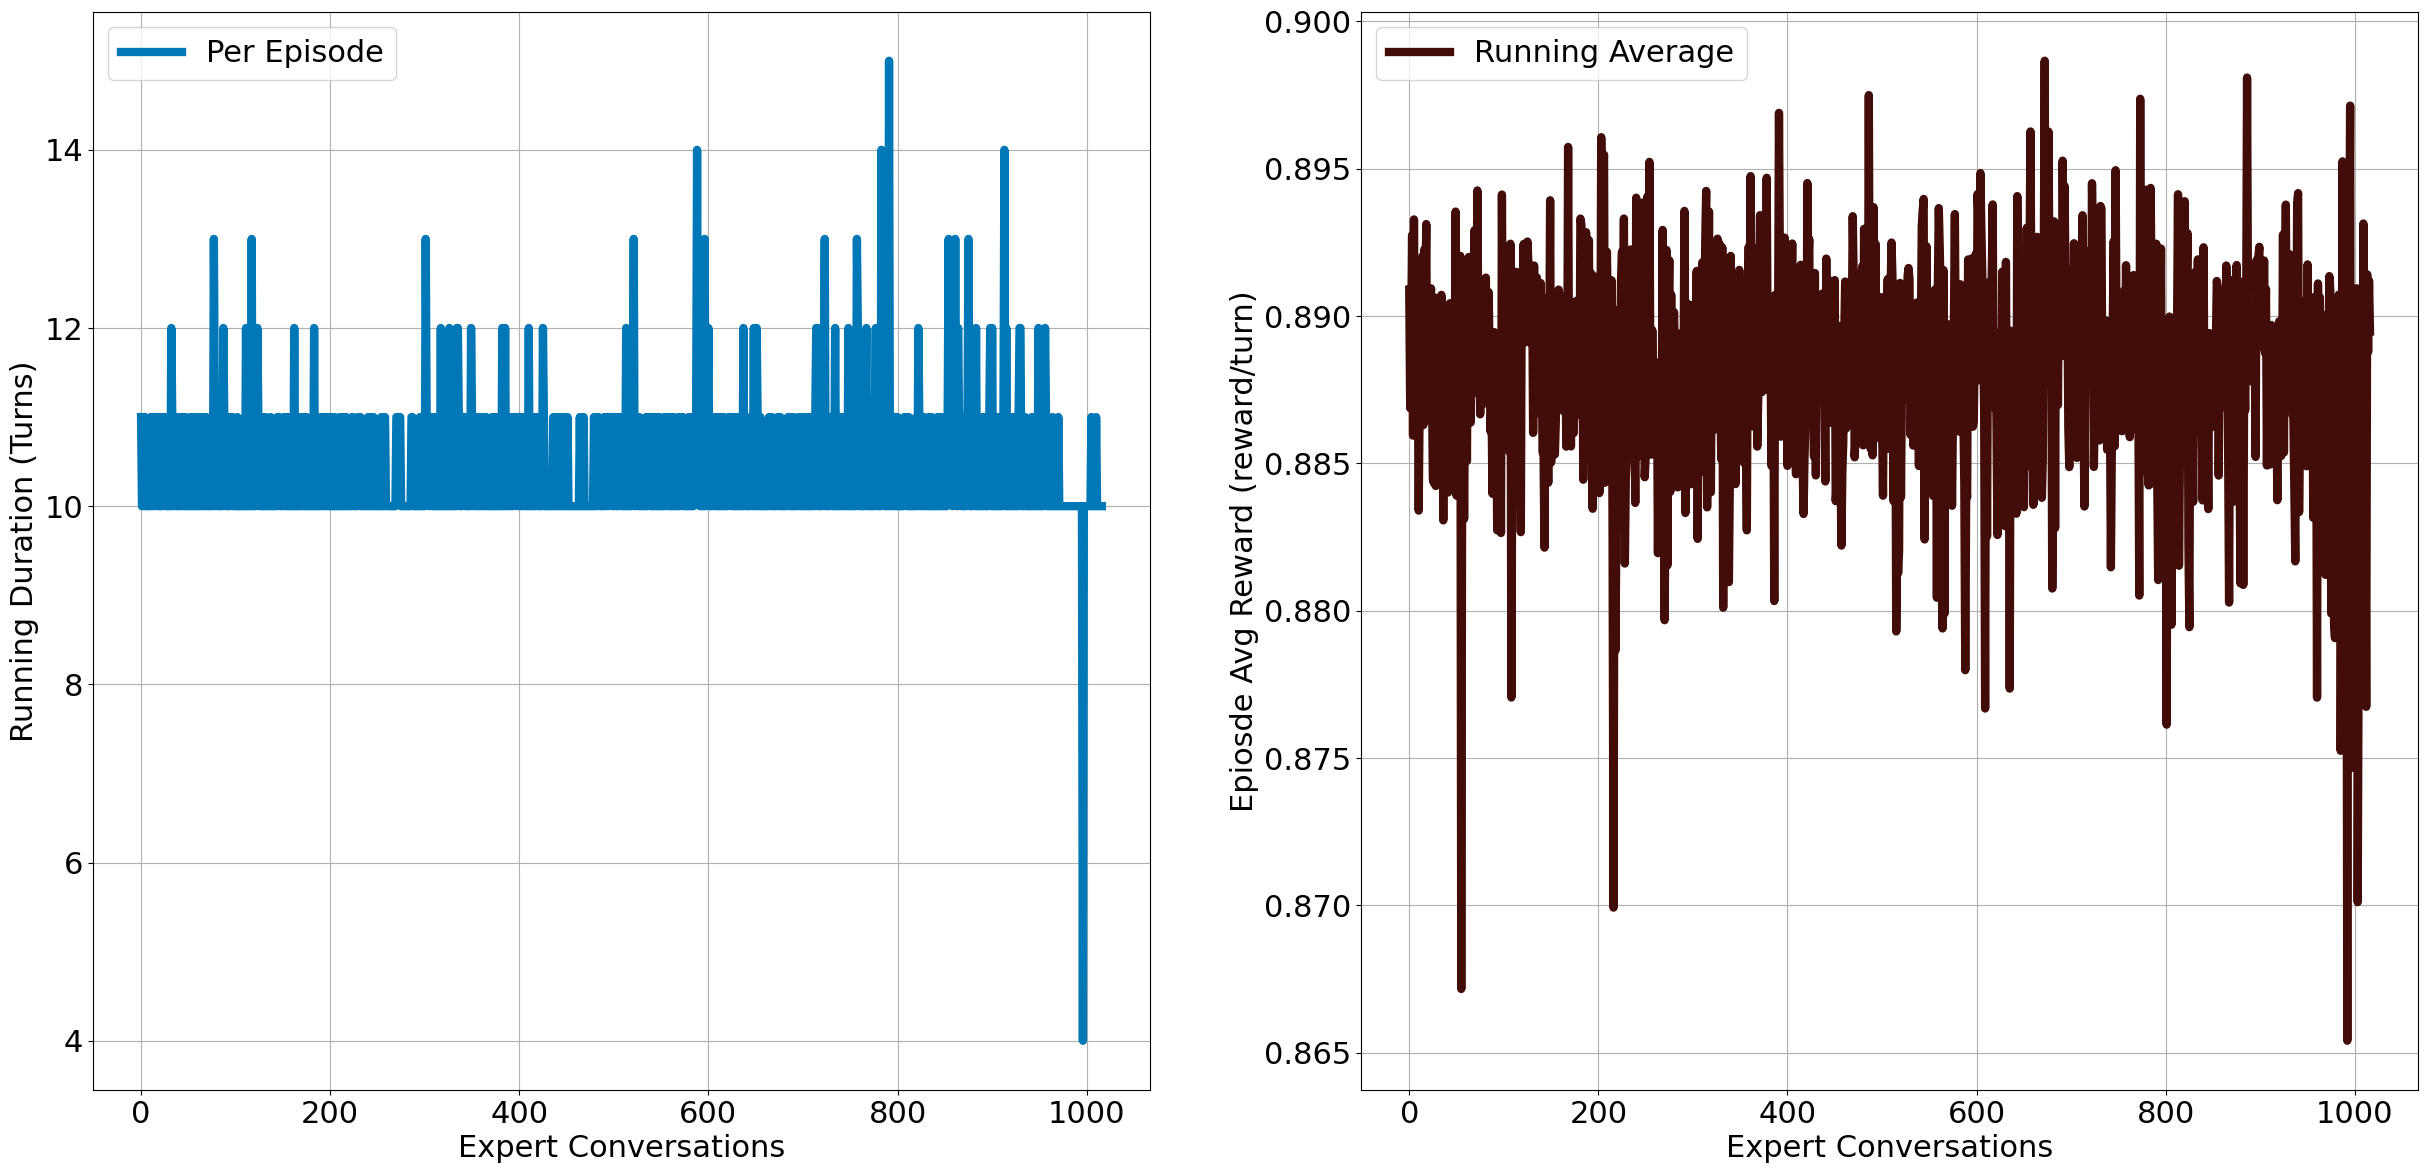

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,14)
plt.rcParams["font.size"] = 22

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('Expert Conversations')
ax1.set_ylabel('Running Duration (Turns)')
ax1.plot(episode_durations, linewidth=6, label='Per Episode', color='#0077b6')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Expert Conversations')
ax2.set_ylabel('Epiosde Avg Reward (reward/turn)')
ax2.plot(episode_avg_rewards, linewidth=6, label='Running Average', color='#420c09')
ax2.legend()
ax2.grid(True)

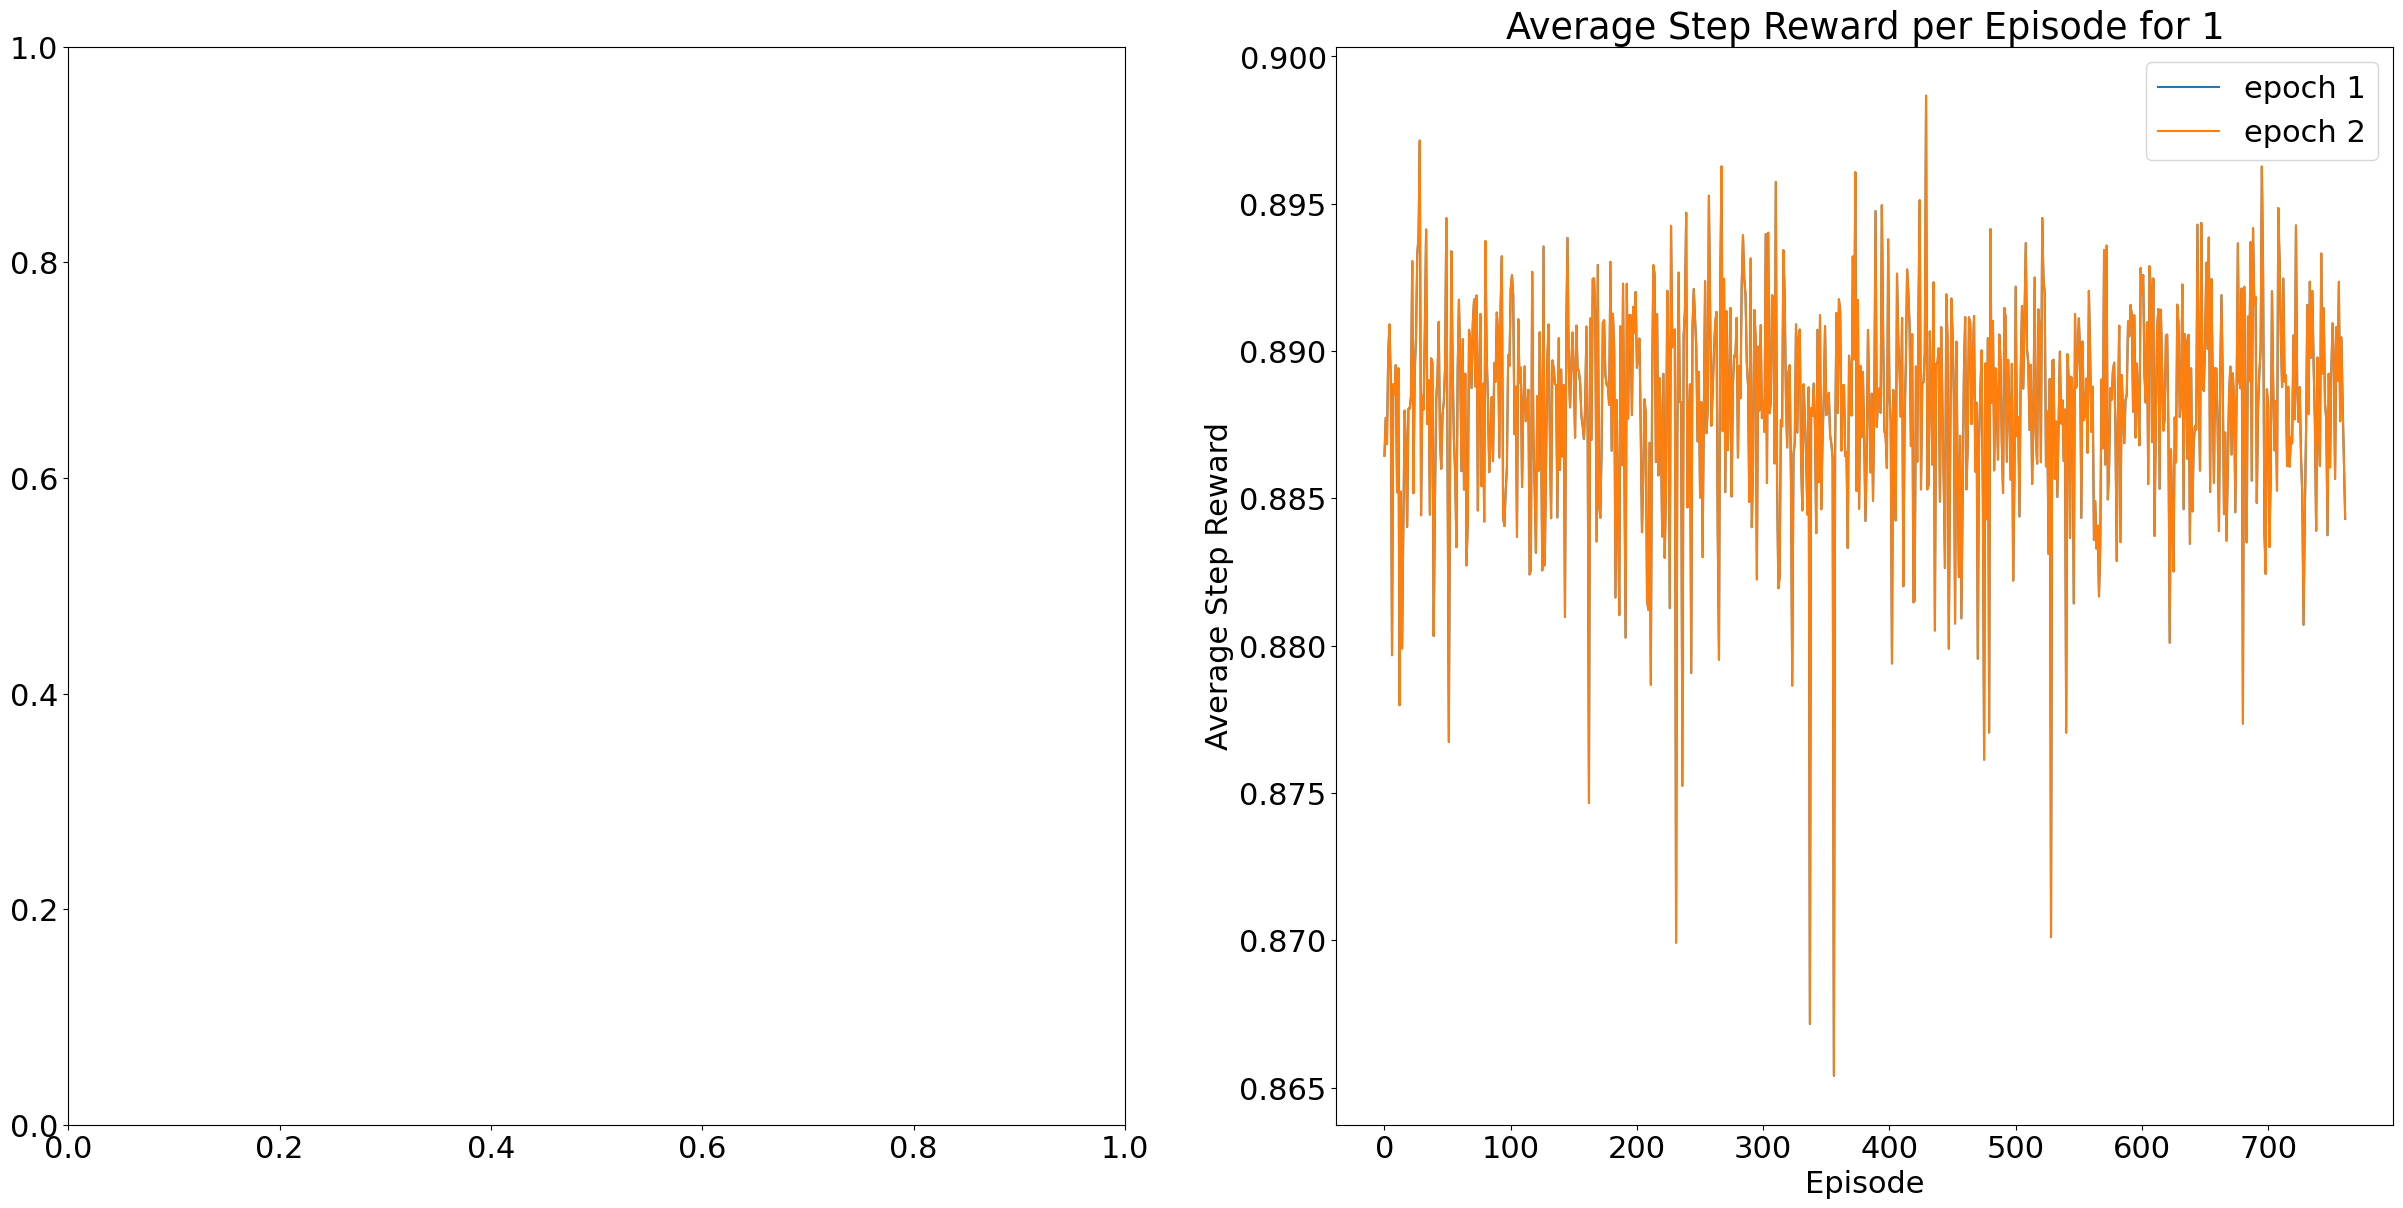

In [28]:

fig, (ax1, ax2) = plt.subplots(1, 2)
for i in range(2):
    epochnum=i
    episode_avg_reward_per_epoch = [value for epoch, value in episode_avg_rewards if epoch == i]


    # Create a line plot of the rewards vs. iterations
    plt.plot(episode_avg_reward_per_epoch)
    plt.xlabel('Episode')
    plt.ylabel('Average Step Reward')
    plt.title(f'Average Step Reward per Episode for {epochnum}')
plt.legend(['epoch 1','epoch 2'])
plt.show()

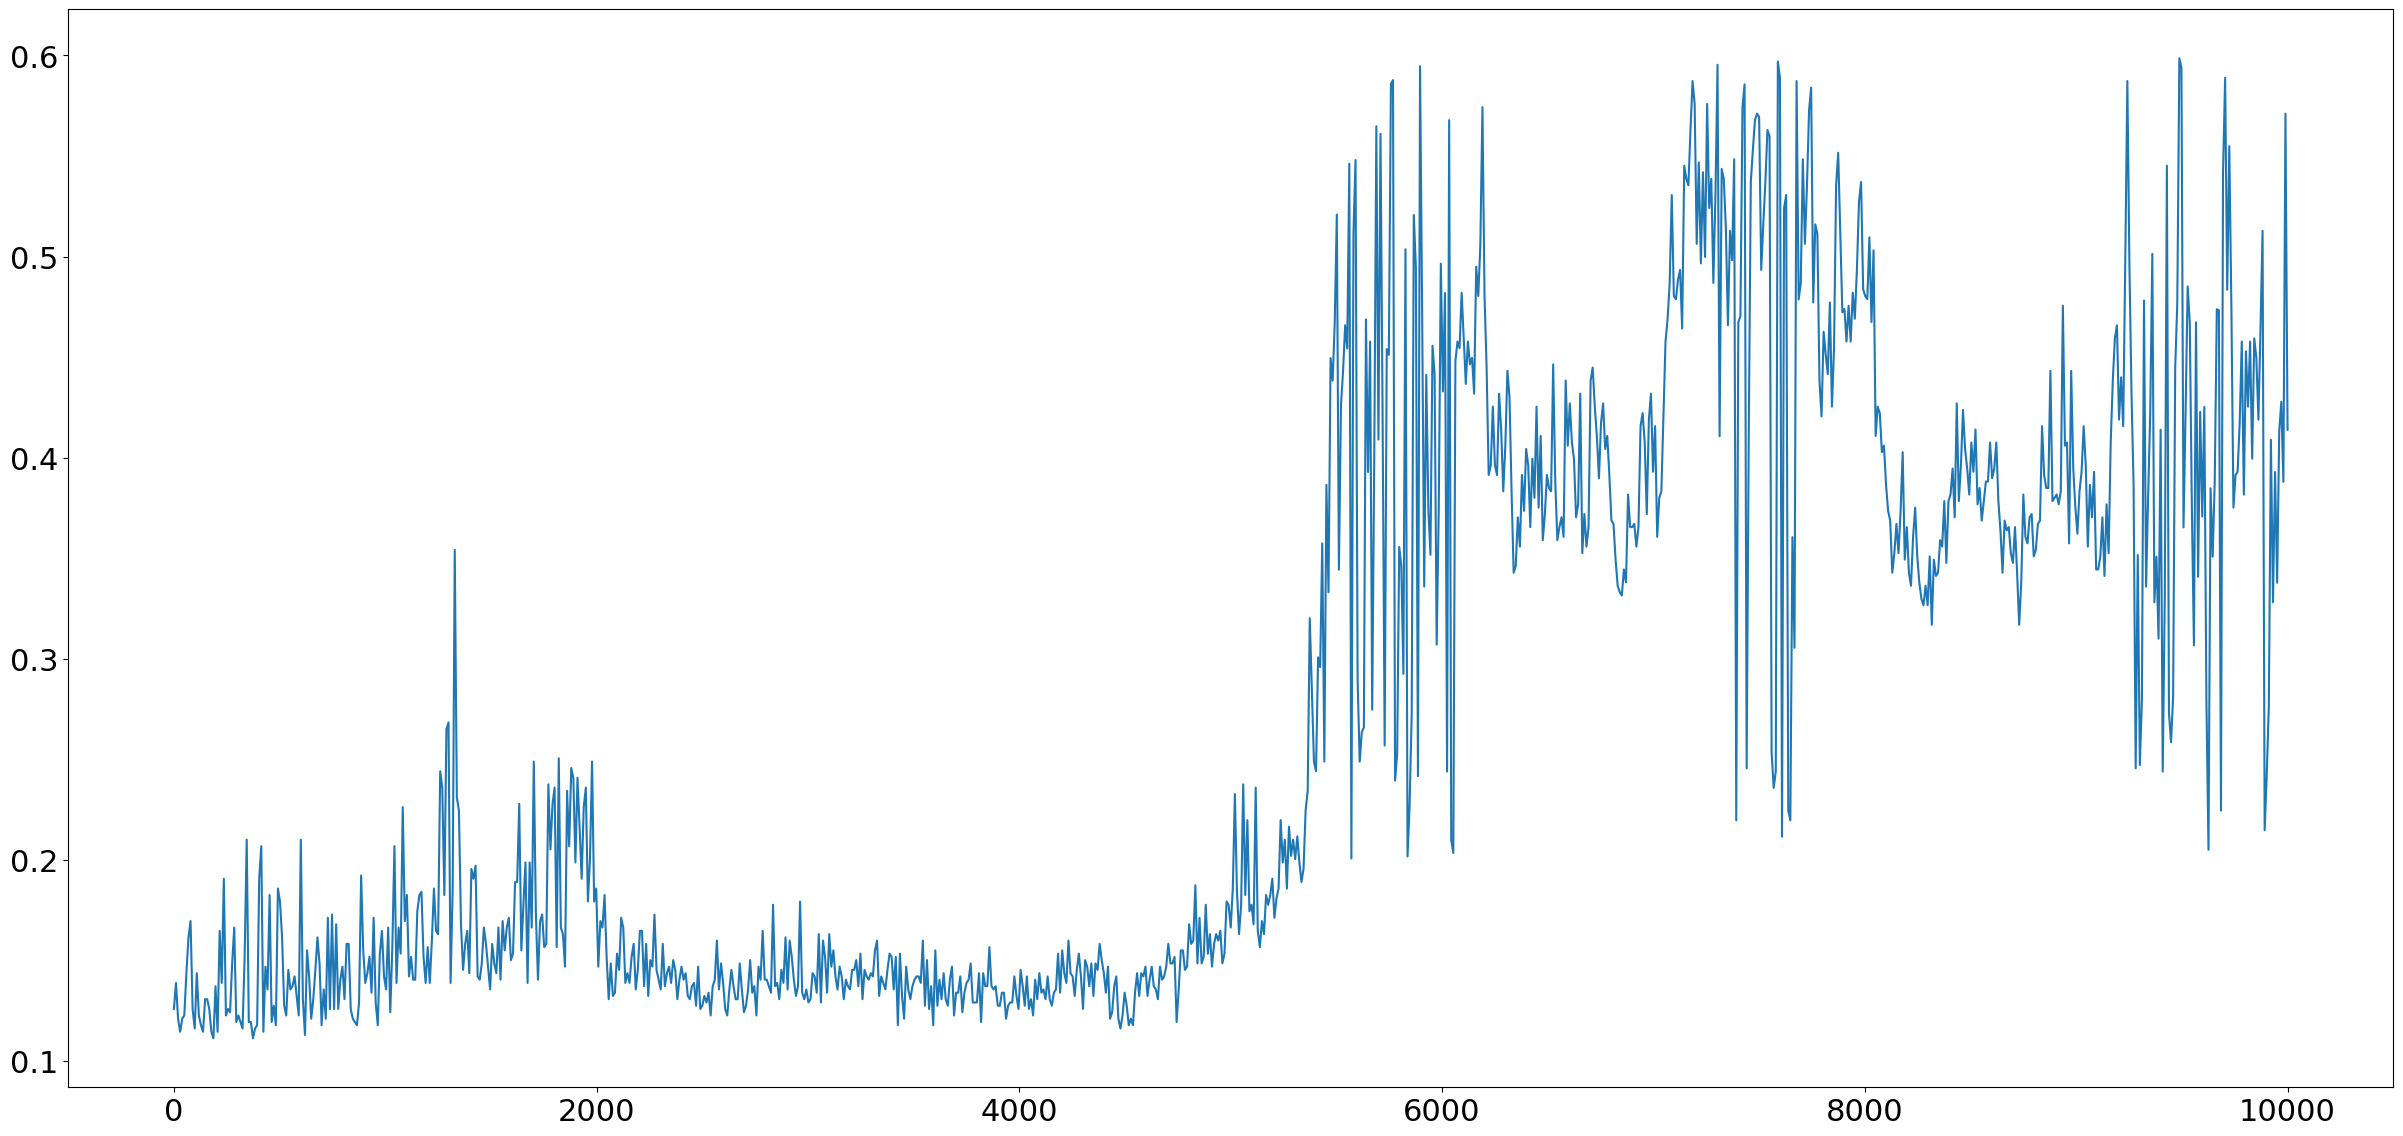

In [26]:
  # display the plot


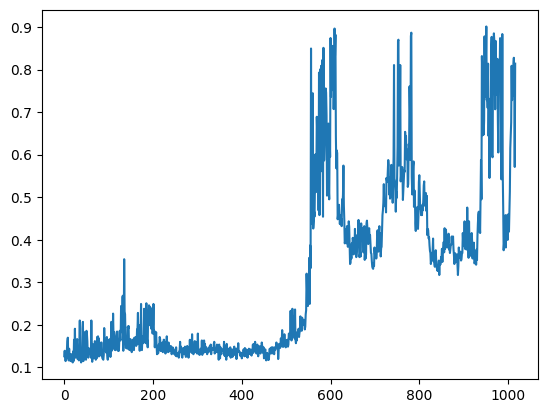

In [29]:
env.render(True)

 Convince people to donate to charities. <persuader>
 I am so livid I just can't stand it right now. Parts of this world are so dark...how can we sit here and do nothing? <persuadee> Do nothing about what? <persuader>
 These poor suffering children! Did you know that 5.6 million children die each year due to treatable AND preventable diseases? <persuadee> That's awful. Are you talking about around the world or in the states?  <persuader>
 Around the world! There is so much that could be done..between preventing the spread of aids, reducing the infant mortality rate with proper education and vaccinations, and ensuring access and aid to proper nutrition so many children could be saved. <persuadee> I totally agree. There are people helping but its a drop in the bucket. The kids dying is really disturbing. They didn't choose that life.  <persuader>
 You are absolutely right. It is disturbing! And yes, it could seem like the aid is a drop in a bucket. However, if we can move the scale one i